# Install Necessary Libraries 

!pip install datasets transformers accelerate

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login

In [ ]:
print(transformers.__version__)

In [15]:
!pip install ipywidgets 
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run script server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


# Loading the Dataset

In [23]:
np.random.seed(42)
from datasets.utils import disable_progress_bar
disable_progress_bar()

In [25]:
dataset = load_dataset("dazzle-nu/CIS435-CreditCardFraudDetection")
df = dataset['train'].to_pandas()

# Sample the Dataset for building the Logistic Regression Model

In [32]:
print(f"Number of original rows and columns in the dataset:{df.shape}")
sample_size = 200000
# Make sure we include a good representation of fraud
df.columns
fraud_df = df[df['is_fraud'] ==1]
non_fraud_df = df[df['is_fraud'] ==0]
# If we have fewer than sample_size rows, use the entire dataset
if len(df) <= sample_size:
    sampled_df = df
else:
# Keep all fraud cases
    non_fraud_sample_size = sample_size - len(fraud_df)
    non_fraud_sampled = non_fraud_df.sample(non_fraud_sample_size, random_state=42)
    sampled_df = pd.concat([fraud_df, non_fraud_sampled], axis= 0)
    sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Shuffle
print(f"Sampled dataset shape:{sampled_df.shape}")
print(f"Fraud cases in sample:{sampled_df['is_fraud'].sum()}({sampled_df['is_fraud'].mean()*100:.2f}%)")
df.columns
df.dtypes

Number of original rows and columns in the dataset:(1048575, 25)
Sampled dataset shape:(200000, 25)
Fraud cases in sample:6006(3.00%)


Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
Unnamed: 23              float64
6006                     float64
dtype: object

# Data Exploration Analysis

In [35]:
# Display some first few rows
first_few_rows = df.head()
display(first_few_rows)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,Unnamed: 23,6006
0,0,1/1/19 0:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",3/9/88,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,NaN,NaN
1,1,1/1/19 0:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,6/21/78,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN,NaN
2,2,1/1/19 0:00,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1/19/62,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,NaN,NaN
3,3,1/1/19 0:01,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1/12/67,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN,NaN
4,4,1/1/19 0:03,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,3/28/86,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,NaN,NaN


Overall Fraud Rate: 0.57%


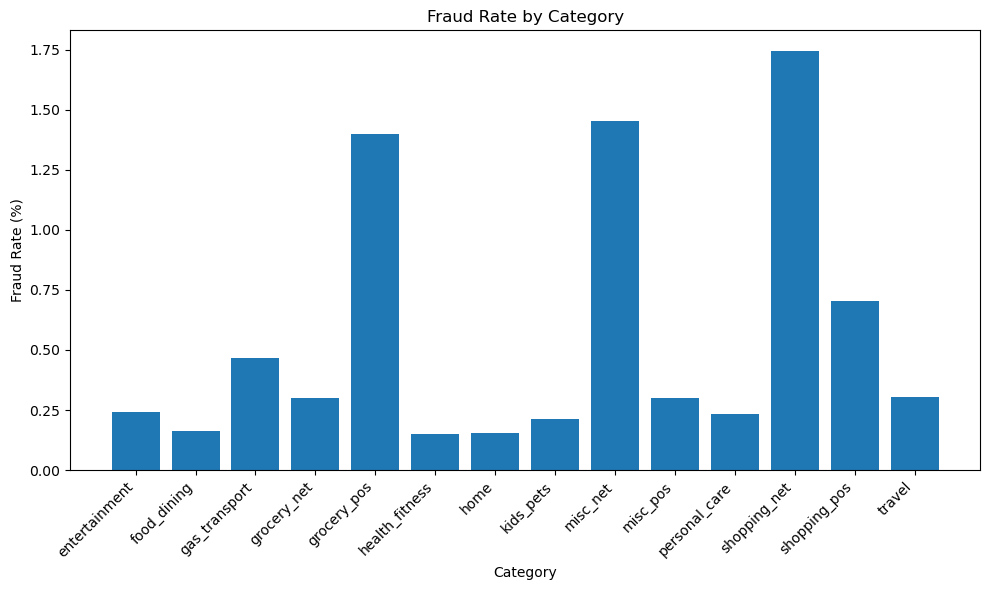

In [37]:
# Distribution of fraud class in the dataset
fraud_rate = df['is_fraud'].sum() / len(df) * 100
print(f"Overall Fraud Rate: {fraud_rate:.2f}%")

# Fraud Rate by category plot
fraud_rate_by_category = df.groupby('category')['is_fraud'].mean() * 100
plt.figure(figsize=(10, 6))
plt.bar(fraud_rate_by_category.index, fraud_rate_by_category.values)
plt.title('Fraud Rate by Category')
plt.xlabel('Category')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [39]:
# Distribution of Categories
print("\nCategory distribution:")
print(sampled_df['category'].value_counts().head())


Category distribution:
category
gas_transport    20466
grocery_pos      19728
home             18771
shopping_pos     17953
kids_pets        17066
Name: count, dtype: int64


In [41]:
# Feature Selection for Logistic Regression model
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
categorical_features = ['category', 'gender', 'state']
# For text-based YiZhao model
text_features = ['merchant', 'category', 'first', 'last', 'city', 'job']

# Base Model: Logistic Regression Model to detect fraud

## Split data into train and test set

In [45]:
X = sampled_df.drop(['is_fraud'], axis = 1)
y = sampled_df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

In [47]:
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 160000 samples
Testing set: 40000 samples


## Build Logistic Regression model

In [50]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [52]:
# Create and train the Logistic Regression model
logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 42))
])

logistic_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'gender',
                                                   'state'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## Model Evaluation

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     38799
           1       0.17      0.73      0.28      1201

    accuracy                           0.89     40000
   macro avg       0.58      0.81      0.61     40000
weighted avg       0.97      0.89      0.92     40000

ROC AUC Score: 0.8985436996442671


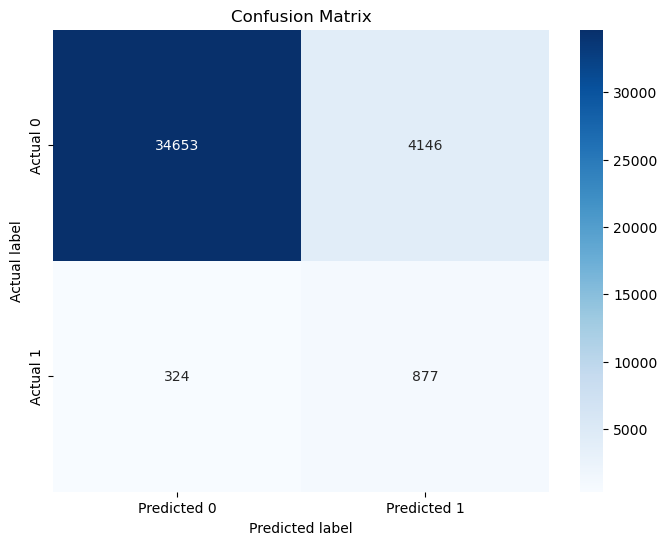

In [55]:
# Model Evaluation
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob)}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Finetune Yizhao Risk-Scoring Model

## Load the Model

In [61]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import logging
logging.set_verbosity_error()


tokenizer = AutoTokenizer.from_pretrained("HIT-TMG/yizhao-risk-en-scorer", use_fast = True)
model = AutoModelForSequenceClassification.from_pretrained("HIT-TMG/yizhao-risk-en-scorer")

In [63]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

## Data Processing for Risk-Scoring Model

In [67]:
text_features = ['merchant', 'category', 'first', 'last', 'city', 'job']

# Transform data into text data for to feed into YiZhao model
def create_text_description(row):
  """Create a text description for each transaction to feed into the YiZhao model """
  description = f"Transaction of ${row['amt']:.2f} at {row['merchant']} in the {row['category']} category "
  description += f"made by {row['first']} {row['last']} from {row['city']}, {row['state']} "
  description += f"with a job title of {row['job']}"
  return description

# Apply this function to the whole 1M rows dataset to create text descriptions from structured tabular data
df['text_description'] = df.apply(create_text_description, axis=1)

In [68]:
print("\nSample text descriptions for YiZhao Risk-Scoring model:")
for i in range(3):
    print(f"Example {i+1}:")
    print(df['text_description'].iloc[i])
    print(f"Fraud: {sampled_df['is_fraud'].iloc[i]}")
    print("---")


Sample text descriptions for YiZhao Risk-Scoring model:
Example 1:
Transaction of $4.97 at fraud_Rippin, Kub and Mann in the misc_net category made by Jennifer Banks from Moravian Falls, NC with a job title of Psychologist, counselling
Fraud: 0
---
Example 2:
Transaction of $107.23 at fraud_Heller, Gutmann and Zieme in the grocery_pos category made by Stephanie Gill from Orient, WA with a job title of Special educational needs teacher
Fraud: 0
---
Example 3:
Transaction of $220.11 at fraud_Lind-Buckridge in the entertainment category made by Edward Sanchez from Malad City, ID with a job title of Nature conservation officer
Fraud: 0
---


## Batch Processing Function

In [ ]:
from tqdm.notebook import tqdm

def tokenize_batch(texts, tokenizer, max_length = 512):
  return tokenizer(
      texts,
      padding='max_length',
      truncation=True,
      max_length=max_length,
      return_tensors="pt"
  )

def get_risk_scores(text_list, batch_size=32):
    risk_scores = []
    if not isinstance(text_list, list):
        text_list = text_list.tolist()
        
    progress_bar = tqdm(range(0, len(text_list), batch_size), 
                        desc="Processing texts", 
                        unit="batch")
    for i in progress_bar:
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits.squeeze(-1).float().cpu().numpy()
        risk_scores.extend(logits.tolist())
        
        progress_bar.set_postfix({"Processed": f"{min(i+batch_size, len(text_list))}/{len(text_list)}"})
        
    return np.array(risk_scores)

## Split data into train and test sets for the risk-scoring model

In [86]:
yizhao_df = df[['text_description', 'is_fraud']].copy()
X_yizhao = yizhao_df['text_description'].values
y_yizhao = yizhao_df['is_fraud'].values
X_train_yizhao, X_test_yizhao, y_train_yizhao, y_test_yizhao = train_test_split(X_yizhao, y_yizhao, test_size=0.2, random_state=42, stratify= y_yizhao)

In [88]:
print(f"YiZhao model training set: {X_train_yizhao.shape[0]} samples")
print(f"YiZhao model test set: {X_test_yizhao.shape[0]} samples")

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

YiZhao model training set: 838860 samples
YiZhao model test set: 209715 samples

Training set: 160000 samples
Testing set: 40000 samples


In [249]:
import time
import sys

def get_risk_scores(text_list, batch_size=32):
    """Get risk scores using the model with a single line progress tracker"""
    total_start_time = time.time()
    risk_scores = []
    total_batches = (len(text_list) + batch_size - 1) // batch_size
    sys.stdout.write(f"Processing 0/{len(text_list)} samples (0.0%) | Elapsed: 0.0s | Remaining: --s")
    sys.stdout.flush()

    for i in range(0, len(text_list), batch_size):
        batch_end = min(i + batch_size, len(text_list))
        batch_texts = text_list[i:batch_end]
        if isinstance(batch_texts, np.ndarray):
            batch_texts = batch_texts.tolist()
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits.squeeze(-1).float().cpu().numpy()
        risk_scores.extend(logits.tolist())
        batch_num = (i // batch_size) + 1
        samples_processed = min(i + batch_size, len(text_list))
        elapsed = time.time() - total_start_time
        percent = samples_processed / len(text_list) * 100
        if batch_num > 1:
            avg_time_per_sample = elapsed / samples_processed
            remaining = avg_time_per_sample * (len(text_list) - samples_processed)
            remaining_str = f"{remaining:.1f}s"
        else:
            remaining_str = "--s"
        sys.stdout.write(f"\rProcessing {samples_processed}/{len(text_list)} samples ({percent:.1f}%) | Elapsed: {elapsed:.1f}s | Remaining: {remaining_str}")
        sys.stdout.flush()
    total_time = time.time() - total_start_time
    sys.stdout.write(f"\rProcessed {len(text_list)}/{len(text_list)} samples (100.0%) | Total time: {total_time:.1f}s | Avg: {total_time/len(text_list)*1000:.2f}ms per sample\n")
    sys.stdout.flush()
    
    return np.array(risk_scores)

print("CALCULATING TRAIN RISK SCORES")
train_risk_scores = get_risk_scores(X_train_yizhao)

print("\nCALCULATING TEST RISK SCORES")
test_risk_scores = get_risk_scores(X_test_yizhao)

print("\nRISK SCORE CALCULATION COMPLETE")

CALCULATING TRAIN RISK SCORES
Processed 838860/838860 samples (100.0%) | Total time: 12589.5s | Avg: 15.01ms per sample

CALCULATING TEST RISK SCORES
Processed 209715/209715 samples (100.0%) | Total time: 2591.4s | Avg: 12.36ms per sample

RISK SCORE CALCULATION COMPLETE


Non-fraud transactions - Mean risk score: 0.3222, Std: 0.1407
Fraud transactions - Mean risk score: 0.3401, Std: 0.1424


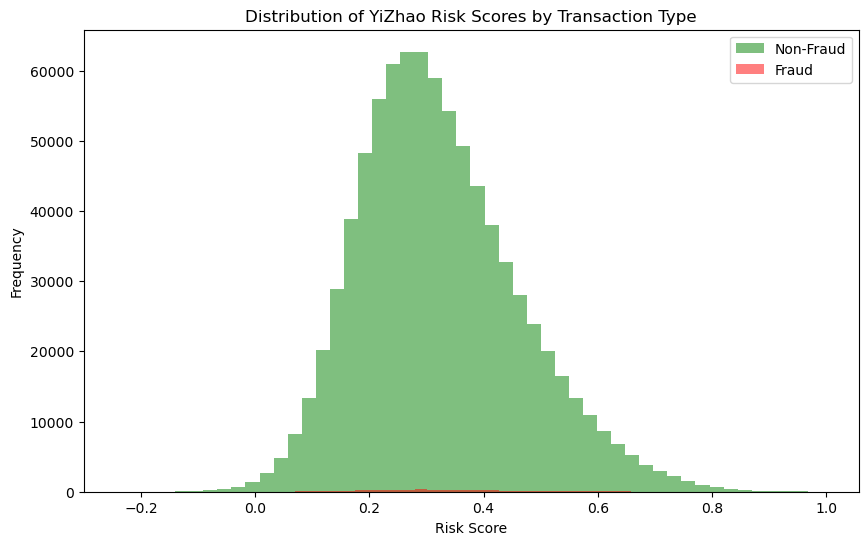

In [252]:
fraud_scores = train_risk_scores[y_train_yizhao == 1]
non_fraud_scores = train_risk_scores[y_train_yizhao == 0]

print(f"Non-fraud transactions - Mean risk score: {non_fraud_scores.mean():.4f}, Std: {non_fraud_scores.std():.4f}")
print(f"Fraud transactions - Mean risk score: {fraud_scores.mean():.4f}, Std: {fraud_scores.std():.4f}")

# Plot distribution of risk scores by fraud/non-fraud
plt.figure(figsize=(10, 6))
plt.hist(non_fraud_scores, bins=50, alpha=0.5, label='Non-Fraud', color='green')
plt.hist(fraud_scores, bins=50, alpha=0.5, label='Fraud', color='red')
plt.title('Distribution of YiZhao Risk Scores by Transaction Type')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Finetune the Risk-Scoring model

## Data Preparation

In [96]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from transformers import get_linear_schedule_with_warmup

In [98]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Make sure DataLoader creation is deterministic
generator = torch.Generator().manual_seed(42)

In [100]:
class FraudTextDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]

            encoding = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding='max_length',
                return_tensors='pt'
            )
            item = {key: val.squeeze(0) for key, val in encoding.items()}
            item['labels'] = torch.tensor(label, dtype=torch.float)

            return item

## Subset Data: I will train the model on 200,000 samples while keeping the fraud rate relatively the same as in the original dataset

In [123]:
fine_tune_sample_size = 200000

# Determine sample size for each class fraud and non-fraud
n_fraud = int(fine_tune_sample_size * 0.2)
n_non_fraud = fine_tune_sample_size - n_fraud  

print(f"Planning to sample {n_fraud} fraud and {n_non_fraud} non-fraud examples")

# Get indices of fraud and non-fraud examples
fraud_indices = np.where(y_train_yizhao == 1)[0]
non_fraud_indices = np.where(y_train_yizhao == 0)[0]

# Sample indices
# Check if we need replacement (if we don't have enough of either class)
use_replacement_fraud = len(fraud_indices) < n_fraud
use_replacement_non_fraud = len(non_fraud_indices) < n_non_fraud

sampled_fraud_indices = np.random.choice(fraud_indices, n_fraud, replace=use_replacement_fraud)
sampled_non_fraud_indices = np.random.choice(non_fraud_indices, n_non_fraud, replace=use_replacement_non_fraud)

# Combine indices
sampled_indices = np.concatenate([sampled_fraud_indices, sampled_non_fraud_indices])
np.random.shuffle(sampled_indices)

Planning to sample 40000 fraud and 160000 non-fraud examples


In [ ]:
# Create fine-tuning dataset
X_fine_tune = X_train_yizhao[sampled_indices]
y_fine_tune = y_train_yizhao[sampled_indices]
print(f"Fine-tuning on {len(X_fine_tune)} samples")
print(f"Fraud cases in fine-tuning: {np.sum(y_fine_tune)} ({np.mean(y_fine_tune)*100:.2f}%)")

## Split into train and test set for finetuning

In [118]:
X_fine_tune_train, X_fine_tune_val, y_fine_tune_train, y_fine_tune_val = train_test_split(
    X_fine_tune, y_fine_tune, test_size=0.2, random_state=42, stratify=y_fine_tune
)

In [112]:
# PyTorch datasets
fine_tune_train_dataset = FraudTextDataset(X_fine_tune_train, y_fine_tune_train, tokenizer)
fine_tune_val_dataset = FraudTextDataset(X_fine_tune_val, y_fine_tune_val, tokenizer)

In [114]:
# Create train and validation datasets
train_dataset = FraudTextDataset(X_train_yizhao, y_train_yizhao, tokenizer)
val_dataset = FraudTextDataset(X_test_yizhao, y_test_yizhao, tokenizer)

# Create DataLoaders
batch_size = 16
fine_tune_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator = generator)
fine_tune_val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## Create a fresh model for fine-tuning

In [126]:
fine_tuned_yizhao_model = AutoModelForSequenceClassification.from_pretrained("HIT-TMG/yizhao-risk-en-scorer")

In [130]:
from torch.optim import AdamW

optimizer = AdamW(
    fine_tuned_yizhao_model.parameters(),
    lr=3e-5,  
    eps=1e-8,
    weight_decay=0.005,
    betas=(0.9, 0.999)  
)

In [132]:
# Epochs
train_dataloader = DataLoader(fine_tune_train_dataset, batch_size=batch_size, shuffle=True)
epochs = 3
total_steps = len(train_dataloader) * epochs

# Scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(0.1 * total_steps),
                                            num_training_steps=total_steps)

## Set up device

In [135]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

fine_tuned_yizhao_model.to(device)

Using device: cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

## Train the model

In [138]:
np.random.seed(42)

In [140]:
fine_tuned_yizhao_model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

In [142]:
# Evaluation metrics
train_losses = []
val_accuracies = []
val_f1_scores = []

In [148]:
fraud_count = 0
sampled_indices = list(SubsetRandomSampler(range(160000)))
for idx in sampled_indices:
      if fine_tune_train_dataset.labels[idx] == 1:
        fraud_count += 1

non_fraud_count = len(sampled_indices) - fraud_count
print(f"Class balance in training subset: {fraud_count} fraud ({fraud_count/len(sampled_indices)*100:.2f}%), {non_fraud_count} non-fraud")


Class balance in training subset: 32000 fraud (20.00%), 128000 non-fraud


In [164]:
import time

In [166]:
# Training function
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0
    train_subset_size = 160000  
    
    fine_tune_train_subset_dataloader = DataLoader(
        fine_tune_train_dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(range(train_subset_size)),
        shuffle=False
    )
    
    # Training
    print(f"Training on {train_subset_size} samples ({len(fine_tune_train_subset_dataloader)} batches)")
    
    total_batches = len(fine_tune_train_subset_dataloader)
    start_time = time.time()
    
    fine_tuned_yizhao_model.train()
    for batch_idx, batch in enumerate(fine_tune_train_subset_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        # Forward pass
        outputs = fine_tuned_yizhao_model(**batch)
        loss = outputs.loss
        # Backward pass
        loss.backward()
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(fine_tuned_yizhao_model.parameters(), 1.0)
        # Update weights
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        

        batch_num = batch_idx + 1
        percent = batch_num / total_batches * 100
        elapsed = time.time() - start_time
        remaining = elapsed / batch_num * (total_batches - batch_num) if batch_num > 0 else 0
        
        print(f"Training: {batch_num}/{total_batches} ({percent:.1f}%) | Loss: {loss.item():.4f} | Elapsed: {elapsed:.1f}s | Remaining: {remaining:.1f}s", end="\r")

    print()
    
    avg_train_loss = total_loss / total_batches
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # Validation
    fine_tuned_yizhao_model.eval()
    val_preds = []
    val_true = []
    val_probs = []
    
    val_subset_size = 32000 
    
    # Create a subset validation dataloader
    fine_tune_val_subset_dataloader = DataLoader(
        fine_tune_val_dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(range(val_subset_size)),
        shuffle=False
    )
    
    print(f"Validating on {val_subset_size} samples ({len(fine_tune_val_subset_dataloader)} batches)")
    
    total_val_batches = len(fine_tune_val_subset_dataloader)
    val_start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(fine_tune_val_subset_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = fine_tuned_yizhao_model(**batch)
            logits = outputs.logits.squeeze(-1)
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).float()
            val_probs.extend(probs.cpu().numpy())
            val_preds.extend(predictions.cpu().numpy())
            val_true.extend(batch['labels'].cpu().numpy())
            
            # Print validation progress
            batch_num = batch_idx + 1
            percent = batch_num / total_val_batches * 100
            elapsed = time.time() - val_start_time
            remaining = elapsed / batch_num * (total_val_batches - batch_num) if batch_num > 0 else 0
            
            print(f"Validation: {batch_num}/{total_val_batches} ({percent:.1f}%) | Elapsed: {elapsed:.1f}s | Remaining: {remaining:.1f}s", end="\r")
    
    print()


Epoch 1/3
Training on 160000 samples (10000 batches)
Training: 10000/10000 (100.0%) | Loss: 0.0009 | Elapsed: 17855.0s | Remaining: 0.0ss
Average training loss: 0.0265
Validating on 32000 samples (2000 batches)
Validation: 2000/2000 (100.0%) | Elapsed: 937.7s | Remaining: 0.0ss

Epoch 2/3
Training on 160000 samples (10000 batches)
Training: 10000/10000 (100.0%) | Loss: 0.0001 | Elapsed: 14740.5s | Remaining: 0.0ss
Average training loss: 0.0114
Validating on 32000 samples (2000 batches)
Validation: 2000/2000 (100.0%) | Elapsed: 863.2s | Remaining: 0.0ss

Epoch 3/3
Training on 160000 samples (10000 batches)
Training: 10000/10000 (100.0%) | Loss: 0.0000 | Elapsed: 14334.8s | Remaining: 0.0ss
Average training loss: 0.0059
Validating on 32000 samples (2000 batches)
Validation: 2000/2000 (100.0%) | Elapsed: 872.7s | Remaining: 0.0ss


In [168]:
# Calculate validation metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, log_loss

# Calculate accuracy, precision, recall, F1
val_accuracy = accuracy_score(val_true, val_preds)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_true, val_preds, average='binary')
val_auc = roc_auc_score(val_true, val_probs)

# Estimate validation loss using log loss (binary cross-entropy)
estimated_val_loss = log_loss(val_true, val_probs)

# Print validation metrics
print("\nValidation Metrics:")
print(f"Estimated Validation Loss: {estimated_val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC-ROC: {val_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")


Validation Metrics:
Estimated Validation Loss: 0.6223
Validation Accuracy: 0.5531
Validation AUC-ROC: 0.9987
Validation Precision: 0.3085
Validation Recall: 1.0000
Validation F1 Score: 0.4716


In [170]:
# Set back to training mode
fine_tuned_yizhao_model.train()
# Save the fine-tuned model
print("\nSaving fine-tuned model...")
fine_tuned_yizhao_model.save_pretrained("yizhao-finetuned-fraud")
tokenizer.save_pretrained("yizhao-finetuned-fraud")
print("Model saved to 'yizhao-finetuned-fraud'")


Saving fine-tuned model...
Model saved to 'yizhao-finetuned-fraud'


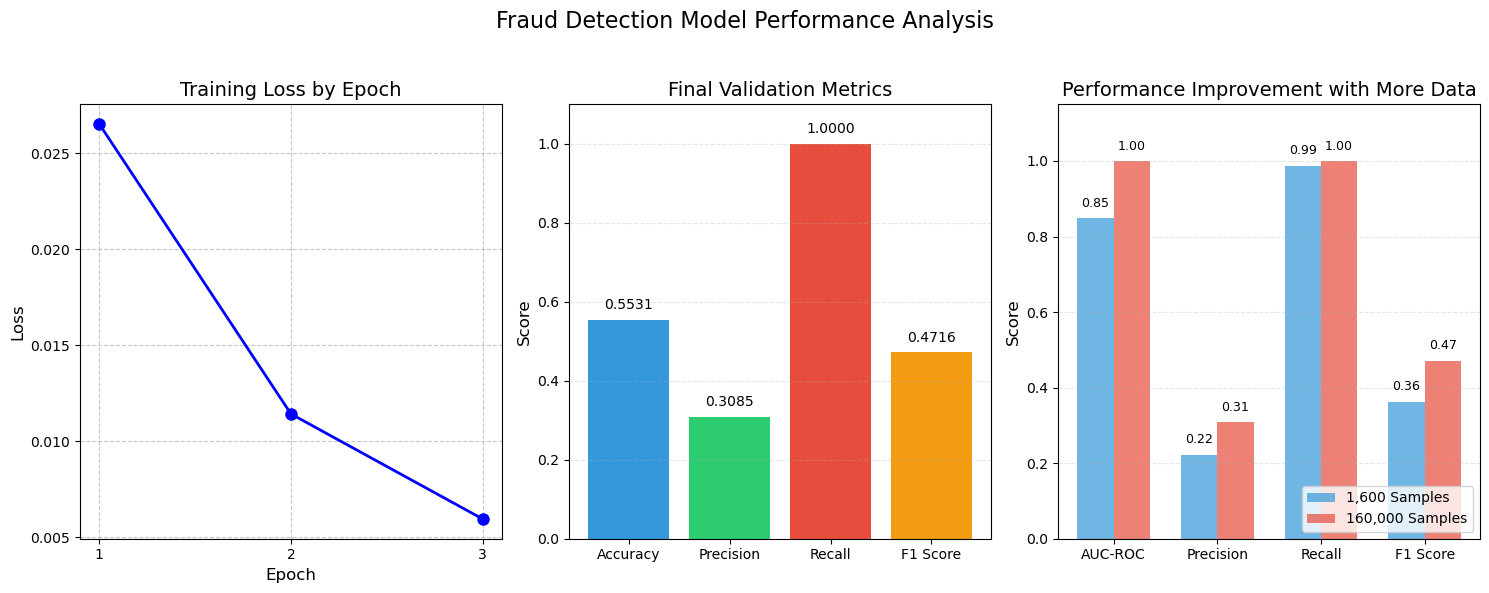

In [178]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
plt.figure(figsize=(15, 6))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-o', linewidth=2, markersize=8)
plt.title('Training Loss by Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(train_losses) + 1))

plt.subplot(1, 3, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.5531, 0.3085, 1.0000, 0.4716] 

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
bars = plt.bar(metrics, values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.title('Final Validation Metrics', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.1) 
plt.grid(True, linestyle='--', alpha=0.3, axis='y')

# Comparison plot
plt.subplot(1, 3, 3)

# Define metrics for both models
metrics = ['AUC-ROC', 'Precision', 'Recall', 'F1 Score']
small_dataset = [0.8485, 0.2225, 0.9875, 0.3632] 
large_dataset = [0.9987, 0.3085, 1.0000, 0.4716]  

x = np.arange(len(metrics))  
width = 0.35  

plt.bar(x - width/2, small_dataset, width, label='1,600 Samples', color='#3498db', alpha=0.7)
plt.bar(x + width/2, large_dataset, width, label='160,000 Samples', color='#e74c3c', alpha=0.7)

for i, v in enumerate(small_dataset):
    plt.text(i - width/2, v + 0.03, f'{v:.2f}', ha='center', fontsize=9)
    
for i, v in enumerate(large_dataset):
    plt.text(i + width/2, v + 0.03, f'{v:.2f}', ha='center', fontsize=9)

plt.title('Performance Improvement with More Data', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xticks(x, metrics)
plt.ylim(0, 1.15) 
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3, axis='y')

plt.suptitle('Fraud Detection Model Performance Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

In [180]:
fine_tuned_yizhao_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

In [184]:
def get_finetuned_risk_scores(text_list, batch_size=32):
    """Get risk scores using the fine-tuned model"""
    risk_scores = []

    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_texts = text_list[i:i+batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_texts.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get risk scores
        with torch.no_grad():
            outputs = fine_tuned_yizhao_model(**inputs)
            logits = outputs.logits.squeeze(-1).float().cpu().numpy()

        risk_scores.extend(logits.tolist())

    return np.array(risk_scores)

# Use a smaller subset for generating scores to save time
max_samples = 5000  # Limit to 5000 samples
X_train_sample = X_train_yizhao[:max_samples]
y_train_sample = y_train_yizhao[:max_samples]
X_test_sample = X_test_yizhao[:max_samples]
y_test_sample = y_test_yizhao[:max_samples]

In [186]:
print("Processing training samples...")
train_risk_scores_finetuned = get_finetuned_risk_scores(X_train_sample)
print("Processing test samples...")
test_risk_scores_finetuned = get_finetuned_risk_scores(X_test_sample)

Processing training samples...


  0%|          | 0/157 [00:00<?, ?it/s]

Processing test samples...


  0%|          | 0/157 [00:00<?, ?it/s]

In [188]:
# Compare original and fine-tuned model distributions
fraud_scores_finetuned = train_risk_scores_finetuned[y_train_sample == 1]
non_fraud_scores_finetuned = train_risk_scores_finetuned[y_train_sample == 0]

print(f"\nFine-tuned model stats:")
print(f"Non-fraud - Mean: {non_fraud_scores_finetuned.mean():.4f}, Std: {non_fraud_scores_finetuned.std():.4f}")
print(f"Fraud - Mean: {fraud_scores_finetuned.mean():.4f}, Std: {fraud_scores_finetuned.std():.4f}")


Fine-tuned model stats:
Non-fraud - Mean: 0.0079, Std: 0.0727
Fraud - Mean: 0.9938, Std: 0.0220


In [254]:
# Get original model scores for same samples size for fair comparison
model.eval()
train_risk_scores_original = get_risk_scores(X_train_sample)
fraud_scores_original = train_risk_scores_original[y_train_sample == 1]
non_fraud_scores_original = train_risk_scores_original[y_train_sample == 0]

print(f"\nOriginal model stats:")
print(f"Non-fraud - Mean: {non_fraud_scores_original.mean():.4f}, Std: {non_fraud_scores_original.std():.4f}")
print(f"Fraud - Mean: {fraud_scores_original.mean():.4f}, Std: {fraud_scores_original.std():.4f}")

Processed 5000/5000 samples (100.0%) | Total time: 54.6s | Avg: 10.92ms per sample

Original model stats:
Non-fraud - Mean: 0.3240, Std: 0.1399
Fraud - Mean: 0.3729, Std: 0.1349


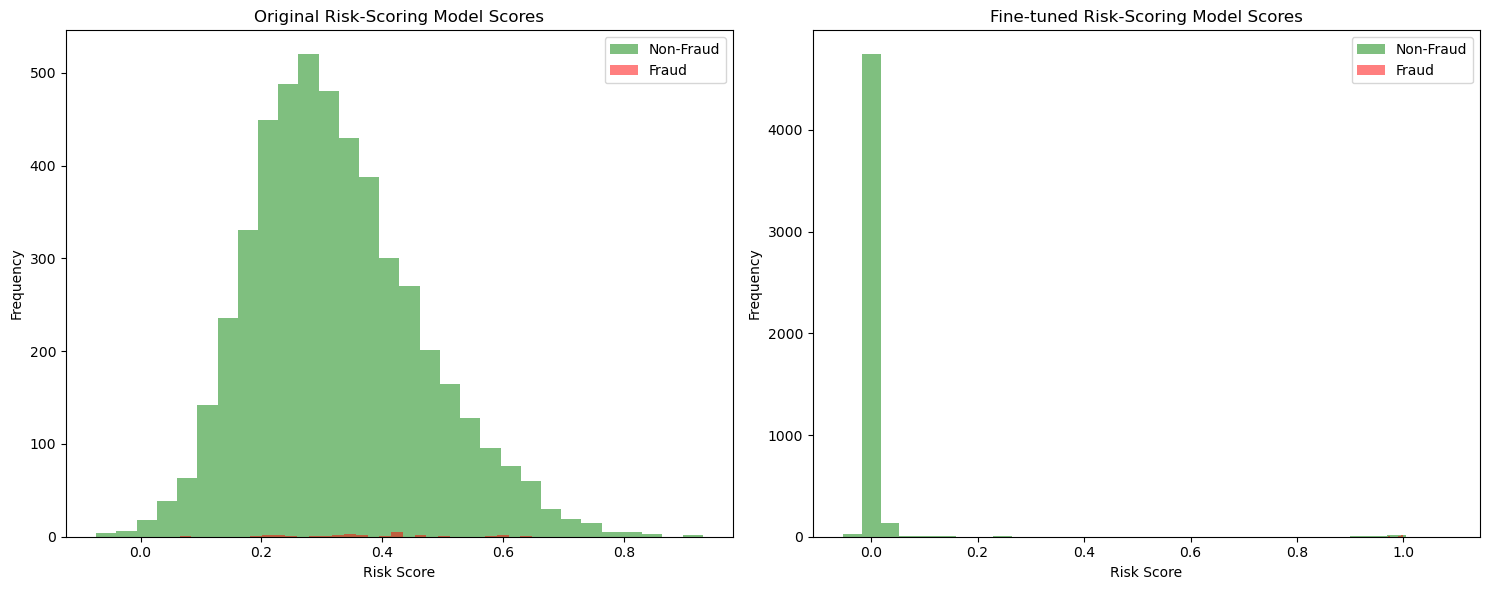

In [256]:
# Plot comparison of original vs fine-tuned distributions
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(non_fraud_scores_original, bins=30, alpha=0.5, label='Non-Fraud', color='green')
plt.hist(fraud_scores_original, bins=30, alpha=0.5, label='Fraud', color='red')
plt.title('Original Risk-Scoring Model Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(non_fraud_scores_finetuned, bins=30, alpha=0.5, label='Non-Fraud', color='green')
plt.hist(fraud_scores_finetuned, bins=30, alpha=0.5, label='Fraud', color='red')
plt.title('Fine-tuned Risk-Scoring Model Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

Test Case Results:

| Transaction | Original Model Score | Fine-tuned Model Score | Expected Risk Level |
|-------------|----------------------|------------------------|---------------------|
| Transaction of $4,999.99 at Un... | 0.4702 | 0.8685 | High risk - Large amount at unknown merchant for gift cards from unemployed customer |
| Transaction of $45.50 at Starb... | 0.1748 | -0.0058 | Low risk - Reasonable amount at common merchant from employed customer |
| Transaction of $2,500.00 at Be... | 0.0636 | 0.0913 | Medium-high risk - High value with suspicious pattern |


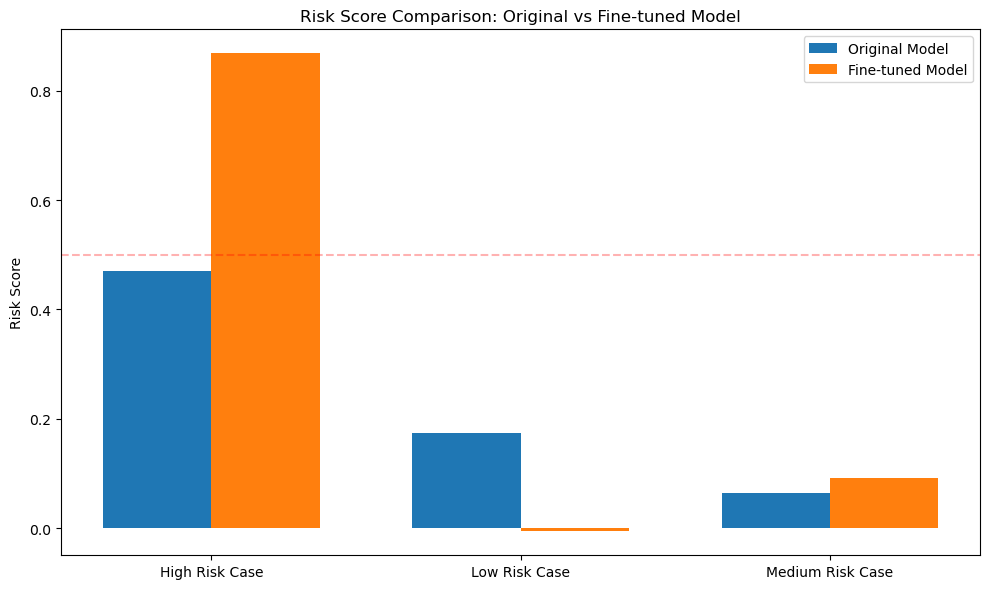

In [204]:
def test_transaction_risk(transaction_text, model, tokenizer, device):
    """
    Test a single transaction description with the model

    Args:
        transaction_text: Text description of the transaction
        model: The YiZhao model (original or fine-tuned)
        tokenizer: The tokenizer for the model
        device: The device to run inference on

    Returns:
        risk_score: The model's risk assessment score
    """
    # Tokenize the text
    inputs = tokenizer([transaction_text], return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Move inputs to the specified device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Move the model to the specified device
    model.to(device)

    # Get risk score
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.squeeze(-1).float().cpu().numpy()

    risk_score = logits[0]

    return risk_score
  # Test case examples
test_cases = [
    {
        "description": "Transaction of $4,999.99 at UnknownMerchant in the gift_card category made by Charles Smith from Chicago, IL. Customer occupation: Unemployed.",
        "expected": "High risk - Large amount at unknown merchant for gift cards from unemployed customer"
    },
    {
        "description": "Transaction of $45.50 at Starbucks in the coffee_shop category made by Mary Johnson from Seattle, WA. Customer occupation: Software Engineer.",
        "expected": "Low risk - Reasonable amount at common merchant from employed customer"
    },
    {
        "description": "Transaction of $2,500.00 at BestBuy in the electronics category made by Tom Wilson from a foreign IP address. Customer has made 3 other high-value purchases in the last 24 hours.",
        "expected": "Medium-high risk - High value with suspicious pattern"
    }
]

# Compare original vs fine-tuned model
print("Test Case Results:\n")
print("| Transaction | Original Model Score | Fine-tuned Model Score | Expected Risk Level |")
print("|-------------|----------------------|------------------------|---------------------|")

for case in test_cases:
    # Get scores from both models
    original_score = test_transaction_risk(case["description"], model, tokenizer, device)
    finetuned_score = test_transaction_risk(case["description"], fine_tuned_yizhao_model, tokenizer, device)

    print(f"| {case['description'][:30]}... | {original_score:.4f} | {finetuned_score:.4f} | {case['expected']} |")

# Visual representation
plt.figure(figsize=(10, 6))
x = range(len(test_cases))
width = 0.35

original_scores = [test_transaction_risk(case["description"], model, tokenizer, device) for case in test_cases]
finetuned_scores = [test_transaction_risk(case["description"], fine_tuned_yizhao_model, tokenizer, device) for case in test_cases]

plt.bar([i - width/2 for i in x], original_scores, width, label='Original Model')
plt.bar([i + width/2 for i in x], finetuned_scores, width, label='Fine-tuned Model')

plt.ylabel('Risk Score')
plt.title('Risk Score Comparison: Original vs Fine-tuned Model')
plt.xticks(x, ['High Risk Case', 'Low Risk Case', 'Medium Risk Case'])
plt.legend()

plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Possible threshold')
plt.tight_layout()
plt.show()

# Statistically Significance Test - See if the fine-tuned model improvement is not just by random variation

## Generate predictions from both models using the same test set

In [222]:
import time

# Function to get predictions from the original model with manual progress tracking
def get_original_model_predictions(text_list, batch_size=32):
    """Get predictions from the original HuggingFace model with manual progress printing"""
    model.eval()  
    probs = []
    
    total_batches = (len(text_list) + batch_size - 1) // batch_size  # Calculate total number of batches
    start_time = time.time()
    
    print(f"Starting original model predictions on {len(text_list)} samples ({total_batches} batches)")
    
    for i in range(0, len(text_list), batch_size):
        batch_idx = i // batch_size
        batch_texts = text_list[i:i+batch_size]
        if isinstance(batch_texts, np.ndarray):
            batch_texts = batch_texts.tolist()
            
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits.squeeze(-1).float().cpu().numpy()
            batch_probs = 1 / (1 + np.exp(-logits))  
            
        probs.extend(batch_probs.tolist())
        
        # Print progress every 10 batches or for the last batch
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
            elapsed = time.time() - start_time
            percent = (batch_idx + 1) / total_batches * 100
            samples_processed = min((batch_idx + 1) * batch_size, len(text_list))
            
            # Calculate estimated time remaining
            if batch_idx > 0:
                time_per_batch = elapsed / (batch_idx + 1)
                remaining = time_per_batch * (total_batches - batch_idx - 1)
            else:
                remaining = 0
                
            print(f"Original model: {samples_processed}/{len(text_list)} samples " +
                  f"({percent:.1f}%) | Batch {batch_idx + 1}/{total_batches} | " +
                  f"Elapsed: {elapsed:.1f}s | Remaining: {remaining:.1f}s")
    
    total_time = time.time() - start_time
    print(f"Original model predictions completed in {total_time:.2f} seconds")
    
    return np.array(probs)

In [224]:
# Function to get predictions from the fine-tuned model with manual progress tracking
def get_finetuned_model_predictions(text_list, batch_size=32):
    """Get predictions from the fine-tuned model with manual progress printing"""
    fine_tuned_yizhao_model.eval()  
    probs = []
    
    total_batches = (len(text_list) + batch_size - 1) // batch_size  # Calculate total number of batches
    start_time = time.time()
    
    print(f"Starting fine-tuned model predictions on {len(text_list)} samples ({total_batches} batches)")
    
    for i in range(0, len(text_list), batch_size):
        batch_idx = i // batch_size
        batch_texts = text_list[i:i+batch_size]
        if isinstance(batch_texts, np.ndarray):
            batch_texts = batch_texts.tolist()
            
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = fine_tuned_yizhao_model(**inputs)
            logits = outputs.logits.squeeze(-1).float().cpu().numpy()
            batch_probs = 1 / (1 + np.exp(-logits))  
            
        probs.extend(batch_probs.tolist())
        
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
            elapsed = time.time() - start_time
            percent = (batch_idx + 1) / total_batches * 100
            samples_processed = min((batch_idx + 1) * batch_size, len(text_list))
            if batch_idx > 0:
                time_per_batch = elapsed / (batch_idx + 1)
                remaining = time_per_batch * (total_batches - batch_idx - 1)
            else:
                remaining = 0
                
            print(f"Fine-tuned model: {samples_processed}/{len(text_list)} samples " +
                  f"({percent:.1f}%) | Batch {batch_idx + 1}/{total_batches} | " +
                  f"Elapsed: {elapsed:.1f}s | Remaining: {remaining:.1f}s")
    
    total_time = time.time() - start_time
    print(f"Fine-tuned model predictions completed in {total_time:.2f} seconds")
    
    return np.array(probs)

# Generate predictions on test set
test_texts = X_test_yizhao  
test_labels = y_test_yizhao  

# Get predictions from both models
print("Starting prediction process...")
original_probs = get_original_model_predictions(test_texts)
print("\nOriginal model predictions complete. Moving to fine-tuned model...\n")
finetuned_probs = get_finetuned_model_predictions(test_texts)
print("\nAll predictions complete!")

Starting prediction process...
Starting original model predictions on 209715 samples (6554 batches)
Original model: 320/209715 samples (0.2%) | Batch 10/6554 | Elapsed: 2.7s | Remaining: 1788.2s
Original model: 640/209715 samples (0.3%) | Batch 20/6554 | Elapsed: 4.9s | Remaining: 1612.5s
Original model: 960/209715 samples (0.5%) | Batch 30/6554 | Elapsed: 7.7s | Remaining: 1669.0s
Original model: 1280/209715 samples (0.6%) | Batch 40/6554 | Elapsed: 10.4s | Remaining: 1687.4s
Original model: 1600/209715 samples (0.8%) | Batch 50/6554 | Elapsed: 12.9s | Remaining: 1680.4s
Original model: 1920/209715 samples (0.9%) | Batch 60/6554 | Elapsed: 16.4s | Remaining: 1770.0s
Original model: 2240/209715 samples (1.1%) | Batch 70/6554 | Elapsed: 20.4s | Remaining: 1892.7s
Original model: 2560/209715 samples (1.2%) | Batch 80/6554 | Elapsed: 24.7s | Remaining: 1996.6s
Original model: 2880/209715 samples (1.4%) | Batch 90/6554 | Elapsed: 28.5s | Remaining: 2047.4s
Original model: 3200/209715 sampl

## Calculate perfomance metrics

In [226]:
def calculate_metrics(y_true, y_pred_probs, threshold = 0.5):
    y_pred = (y_pred_probs > threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_pred_probs)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
# Calculate metrics for both models
original_metrics = calculate_metrics(test_labels, original_probs)
finetuned_metrics = calculate_metrics(test_labels, finetuned_probs)

print("Original Model Metrics:")
for metric, value in original_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nFine-tuned Model Metrics:")
for metric, value in finetuned_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nMetric Improvements:")
for metric in original_metrics:
    improvement = finetuned_metrics[metric] - original_metrics[metric]
    percent_improvement = (improvement / original_metrics[metric]) * 100
    print(f"  {metric}: +{improvement:.4f} ({percent_improvement:.2f}%)")

Original Model Metrics:
  accuracy: 0.0084
  precision: 0.0057
  recall: 0.9992
  f1: 0.0114
  auc: 0.5547

Fine-tuned Model Metrics:
  accuracy: 0.4415
  precision: 0.0100
  recall: 0.9883
  f1: 0.0199
  auc: 0.9777

Metric Improvements:
  accuracy: +0.4331 (5148.64%)
  precision: +0.0043 (74.88%)
  recall: +-0.0108 (-1.08%)
  f1: +0.0085 (74.11%)
  auc: +0.4230 (76.25%)


## Bootstrap Test for AUC
### This test will tell if the improvement in ranking ability is statistically significant

In [231]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

def bootstrap_auc_test(y_true, pred1, pred2, n_bootstraps=2000, ci=0.95):
    """Perform bootstrap test for AUC difference with manual progress printing"""
    auc_diffs = []
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    print(f"Starting bootstrap AUC test with {n_bootstraps} samples...")
    start_time = time.time()
    skipped_samples = 0
    
    # Bootstrap iterations
    for i in range(n_bootstraps):
        if (i + 1) % 100 == 0 or i == 0 or (i + 1) == n_bootstraps:
            elapsed = time.time() - start_time
            percent_complete = (i + 1) / n_bootstraps * 100
            if i > 0:
                time_per_iter = elapsed / (i + 1)
                remaining = time_per_iter * (n_bootstraps - i - 1)
            else:
                remaining = 0
                
            print(f"Bootstrap progress: {i+1}/{n_bootstraps} iterations ({percent_complete:.1f}%) | " +
                  f"Elapsed: {elapsed:.1f}s | Remaining: {remaining:.1f}s | " +
                  f"Skipped samples: {skipped_samples}")
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            skipped_samples += 1
            continue
        auc1 = roc_auc_score(y_true[indices], pred1[indices])
        auc2 = roc_auc_score(y_true[indices], pred2[indices])
        auc_diffs.append(auc2 - auc1)
    total_time = time.time() - start_time
    mean_diff = np.mean(auc_diffs)
    alpha = (1 - ci) / 2
    lower_bound = np.percentile(auc_diffs, 100 * alpha)
    upper_bound = np.percentile(auc_diffs, 100 * (1 - alpha))
    p_value = np.mean(np.array(auc_diffs) <= 0)
    
    print(f"\nBootstrap completed in {total_time:.2f} seconds")
    print(f"Processed {len(auc_diffs)} valid bootstrap samples (skipped {skipped_samples} due to class imbalance)")
    
    print(f"\nBootstrap AUC Test Results (n={n_bootstraps}):")
    print(f"  Mean AUC difference: {mean_diff:.6f}")
    print(f"  {ci*100}% Confidence Interval: [{lower_bound:.6f}, {upper_bound:.6f}]")
    print(f"  p-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("  Conclusion: The improvement in AUC is STATISTICALLY SIGNIFICANT (p < 0.05)")
    else:
        print("  Conclusion: The improvement in AUC is NOT statistically significant (p >= 0.05)")
    
    return mean_diff, lower_bound, upper_bound, p_value

# Perform bootstrap test for AUC difference
print("Starting statistical significance testing...")
bootstrap_results = bootstrap_auc_test(test_labels, original_probs, finetuned_probs)
print("Statistical testing complete!")

Starting statistical significance testing...
Starting bootstrap AUC test with 2000 samples...
Bootstrap progress: 1/2000 iterations (0.1%) | Elapsed: 0.0s | Remaining: 0.0s | Skipped samples: 0
Bootstrap progress: 100/2000 iterations (5.0%) | Elapsed: 16.8s | Remaining: 319.1s | Skipped samples: 0
Bootstrap progress: 200/2000 iterations (10.0%) | Elapsed: 33.7s | Remaining: 303.2s | Skipped samples: 0
Bootstrap progress: 300/2000 iterations (15.0%) | Elapsed: 49.4s | Remaining: 279.9s | Skipped samples: 0
Bootstrap progress: 400/2000 iterations (20.0%) | Elapsed: 65.4s | Remaining: 261.7s | Skipped samples: 0
Bootstrap progress: 500/2000 iterations (25.0%) | Elapsed: 82.4s | Remaining: 247.3s | Skipped samples: 0
Bootstrap progress: 600/2000 iterations (30.0%) | Elapsed: 98.2s | Remaining: 229.1s | Skipped samples: 0
Bootstrap progress: 700/2000 iterations (35.0%) | Elapsed: 118.4s | Remaining: 219.8s | Skipped samples: 0
Bootstrap progress: 800/2000 iterations (40.0%) | Elapsed: 133.9

## McNemar Test for Binary Classification
### This test will tell if the risk-scoring model makes significantly different and better predictions

In [243]:
import time
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(y_true, pred1, pred2):
    """Perform McNemar's test for comparing two classifiers with time tracking"""
    print("Starting McNemar's test...")
    start_time = time.time()
    
    print("Step 1: Converting probabilities to binary predictions...")
    step_start = time.time()
    pred1_binary = (pred1 >= 0.5).astype(int)
    pred2_binary = (pred2 >= 0.5).astype(int)
    step_end = time.time()
    print(f"  Conversion completed in {step_end - step_start:.2f} seconds")
    
    print("Step 2: Creating contingency table...")
    step_start = time.time()
    correct1 = pred1_binary == y_true
    correct2 = pred2_binary == y_true
    
    both_correct = sum(correct1 & correct2)
    model1_only_correct = sum(correct1 & ~correct2)
    model2_only_correct = sum(~correct1 & correct2)
    both_incorrect = sum(~correct1 & ~correct2)
    
    table = [[both_correct, model1_only_correct], 
             [model2_only_correct, both_incorrect]]
    
    step_end = time.time()
    print(f"  Contingency table created in {step_end - step_start:.2f} seconds")
    print(f"  Contingency table: {table}")
    
    print("Step 3: Performing McNemar's statistical test...")
    step_start = time.time()
    result = mcnemar(table, exact=True)
    step_end = time.time()
    print(f"  Statistical test completed in {step_end - step_start:.2f} seconds")
    total_time = time.time() - start_time
    
    print("\nMcNemar's Test Results:")
    print(f"  Test statistic: {result.statistic:.4f}")
    print(f"  p-value: {result.pvalue:.6f}")
    
    if result.pvalue < 0.05:
        print("  Conclusion: The difference between the models is STATISTICALLY SIGNIFICANT (p < 0.05)")
    else:
        print("  Conclusion: The difference between the models is NOT statistically significant (p >= 0.05)")
    
    print(f"\nTotal execution time: {total_time:.2f} seconds")
    
    print("\nContingency Table Interpretation:")
    print(f"  Both models correct: {both_correct} samples")
    print(f"  Only original model correct: {model1_only_correct} samples")
    print(f"  Only fine-tuned model correct: {model2_only_correct} samples")
    print(f"  Both models incorrect: {both_incorrect} samples")
    
    acc1 = (both_correct + model1_only_correct) / len(y_true)
    acc2 = (both_correct + model2_only_correct) / len(y_true)
    
    print(f"\nAccuracy Comparison:")
    print(f"  Original model accuracy: {acc1:.4f}")
    print(f"  Fine-tuned model accuracy: {acc2:.4f}")
    print(f"  Accuracy difference: {acc2 - acc1:.4f}")
    
    return result

# Perform McNemar's test
print("\n" + "="*60)
print("STARTING MCNEMAR'S TEST FOR STATISTICAL SIGNIFICANCE")
print("="*60 + "\n")

mcnemar_result = mcnemar_test(test_labels, original_probs, finetuned_probs)

print("\n" + "="*60)
print("MCNEMAR'S TEST COMPLETED")
print("="*60)


STARTING MCNEMAR'S TEST FOR STATISTICAL SIGNIFICANCE

Starting McNemar's test...
Step 1: Converting probabilities to binary predictions...
  Conversion completed in 0.00 seconds
Step 2: Creating contingency table...
  Contingency table created in 0.05 seconds
  Contingency table: [[1432, 332], [91152, 116799]]
Step 3: Performing McNemar's statistical test...
  Statistical test completed in 0.00 seconds

McNemar's Test Results:
  Test statistic: 332.0000
  p-value: 0.000000
  Conclusion: The difference between the models is STATISTICALLY SIGNIFICANT (p < 0.05)

Total execution time: 0.06 seconds

Contingency Table Interpretation:
  Both models correct: 1432 samples
  Only original model correct: 332 samples
  Only fine-tuned model correct: 91152 samples
  Both models incorrect: 116799 samples

Accuracy Comparison:
  Original model accuracy: 0.0084
  Fine-tuned model accuracy: 0.4415
  Accuracy difference: 0.4331

MCNEMAR'S TEST COMPLETED


C:\Users\Home\AppData\Local\Temp\ipykernel_32492\435873795.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_probs[test_labels==0], label='Original - Non-fraud', color='blue', shade=True, alpha=0.3)
C:\Users\Home\AppData\Local\Temp\ipykernel_32492\435873795.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_probs[test_labels==1], label='Original - Fraud', color='red', shade=True, alpha=0.3)
C:\Users\Home\AppData\Local\Temp\ipykernel_32492\435873795.py:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(finetuned_probs[test_labels==0], label='Fine-tuned - Non-fraud', color='blue', shade=True, alpha=0.

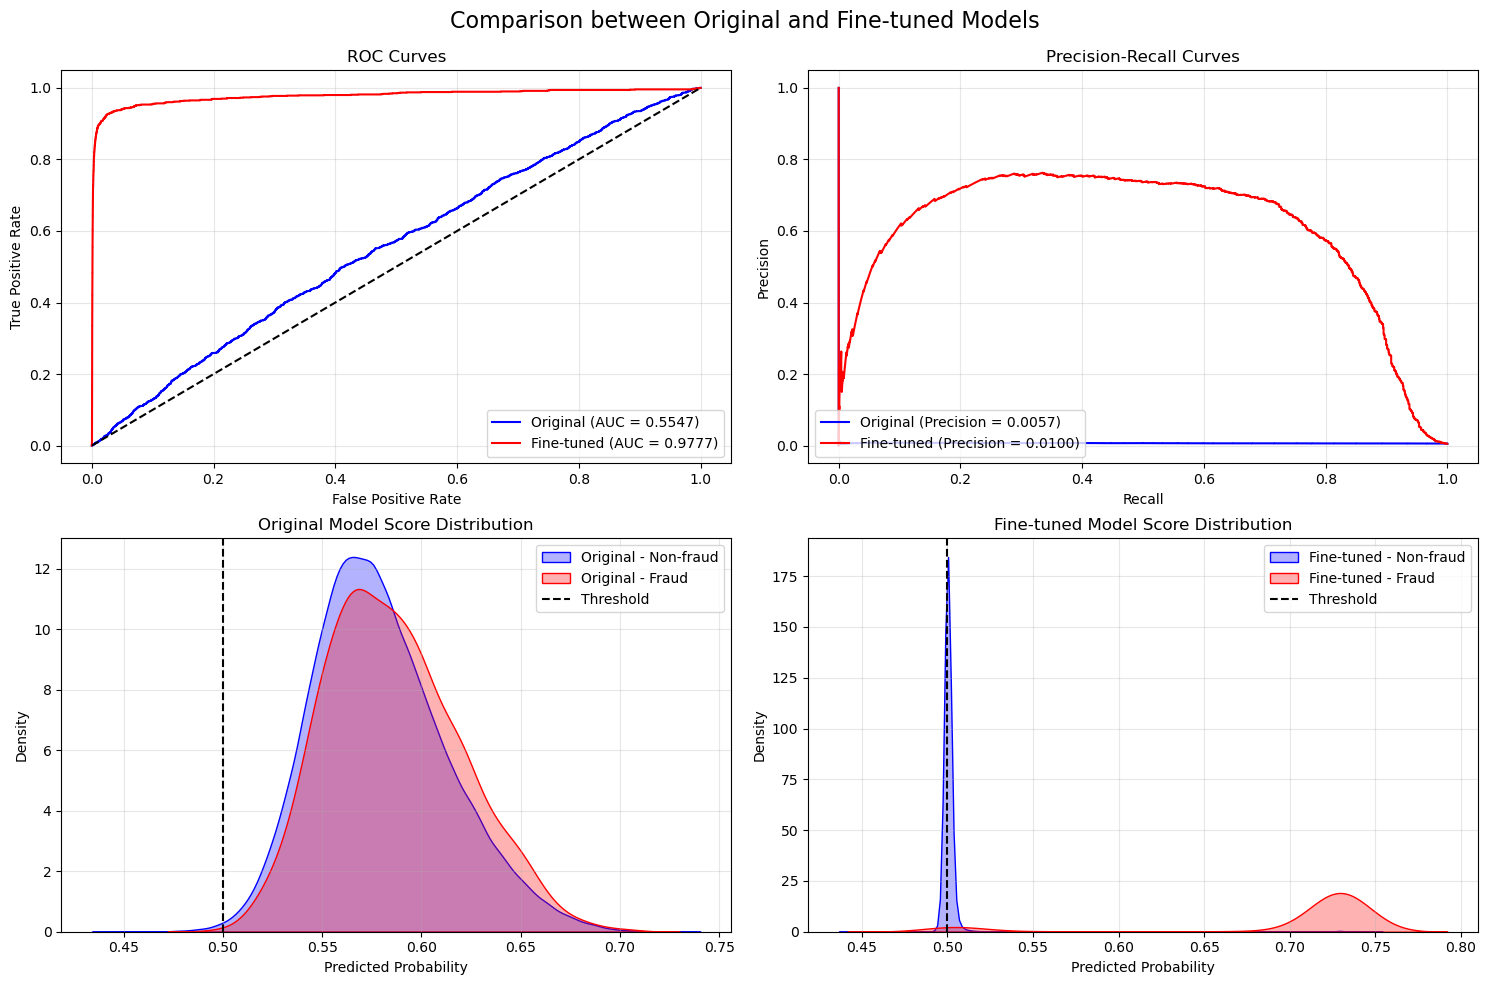

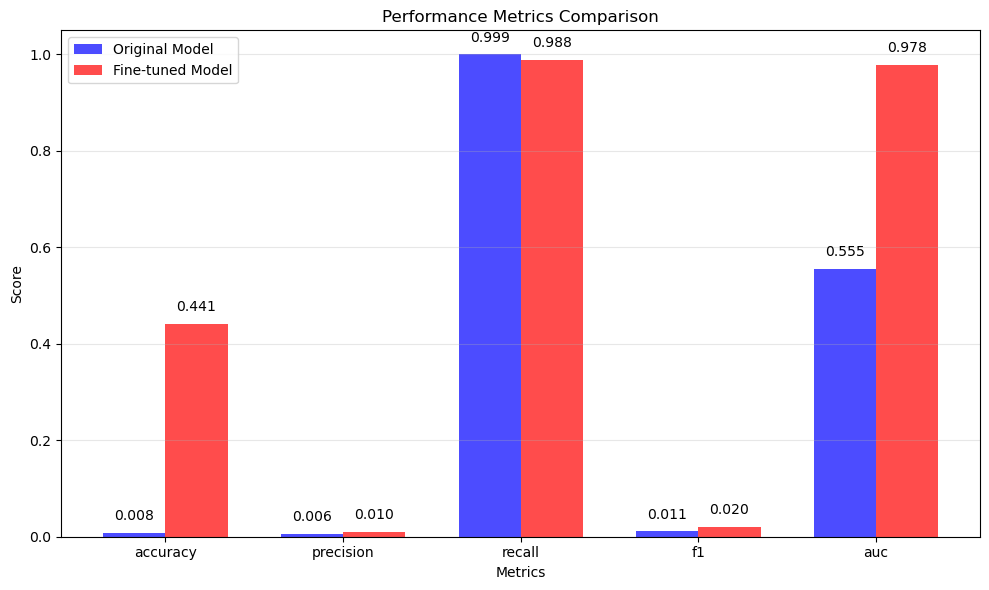

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

# Create a visualization of the differences
plt.figure(figsize=(15, 10))

# 1. ROC curves
plt.subplot(2, 2, 1)
fpr1, tpr1, _ = roc_curve(test_labels, original_probs)
fpr2, tpr2, _ = roc_curve(test_labels, finetuned_probs)

plt.plot(fpr1, tpr1, 'b-', label=f'Original (AUC = {original_metrics["auc"]:.4f})')
plt.plot(fpr2, tpr2, 'r-', label=f'Fine-tuned (AUC = {finetuned_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# 2. Precision-Recall curves
plt.subplot(2, 2, 2)
precision1, recall1, _ = precision_recall_curve(test_labels, original_probs)
precision2, recall2, _ = precision_recall_curve(test_labels, finetuned_probs)

plt.plot(recall1, precision1, 'b-', label=f'Original (Precision = {original_metrics["precision"]:.4f})')
plt.plot(recall2, precision2, 'r-', label=f'Fine-tuned (Precision = {finetuned_metrics["precision"]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

# 3. Score distributions
plt.subplot(2, 2, 3)
sns.kdeplot(original_probs[test_labels==0], label='Original - Non-fraud', color='blue', shade=True, alpha=0.3)
sns.kdeplot(original_probs[test_labels==1], label='Original - Fraud', color='red', shade=True, alpha=0.3)
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Original Model Score Distribution')
plt.legend()
plt.grid(alpha=0.3)

# 4. Score distributions
plt.subplot(2, 2, 4)
sns.kdeplot(finetuned_probs[test_labels==0], label='Fine-tuned - Non-fraud', color='blue', shade=True, alpha=0.3)
sns.kdeplot(finetuned_probs[test_labels==1], label='Fine-tuned - Fraud', color='red', shade=True, alpha=0.3)
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Fine-tuned Model Score Distribution')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Comparison between Original and Fine-tuned Models', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

# 5. Metrics comparison bar chart
plt.figure(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x = np.arange(len(metrics))
width = 0.35

original_values = [original_metrics[m] for m in metrics]
finetuned_values = [finetuned_metrics[m] for m in metrics]

plt.bar(x - width/2, original_values, width, label='Original Model', color='blue', alpha=0.7)
plt.bar(x + width/2, finetuned_values, width, label='Fine-tuned Model', color='red', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(alpha=0.3, axis='y')

for i, v in enumerate(original_values):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
    
for i, v in enumerate(finetuned_values):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Both tests show that the improvements in the fine-tuned Risk-Scoring model are statistically significant and not due to random variation.